In [4]:
import importlib
import torch
import models
import hotrg_torch
from opt_einsum import contract
importlib.reload(models)
importlib.reload(hotrg_torch)

<module 'hotrg_torch' from 'c:\\Users\\timot\\OneDrive - The Chinese University of Hong Kong\\Desktop\\misc trash\\diff-hotrg\\hotrg_torch.py'>

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
torch.set_default_dtype(torch.float64)
torch.set_default_device(device)
torch.get_default_device()

device(type='cuda', index=0)

In [7]:
import numpy as np
Tc = models.Ising2D.Tc
dlnZdT_th= []
d2lnZdT2_th = []
lnZ_th = []
Nsamples = 100
Ts = np.linspace(0.8*Tc,1.2*Tc,Nsamples)
for T in np.linspace(0.8*Tc,1.2*Tc,Nsamples):
    #with torch.autograd.detect_anomaly():
    temp = torch.Tensor([T]).to(device)
    temp.requires_grad_()
    model = models.Ising2D(temp)
    lnZ = model.get_lnZ()

    dlnZdT, = torch.autograd.grad(lnZ,temp,create_graph=True)
    d2lnZdT2, = torch.autograd.grad(dlnZdT,temp)
    dlnZdT_th.append(dlnZdT.item())
    d2lnZdT2_th.append(d2lnZdT2.item())
    lnZ_th.append(lnZ.item())
dlnZdT_th = np.array(dlnZdT_th)
d2lnZdT2_th = np.array(d2lnZdT2_th)

Text(0, 0.5, 'energy density')

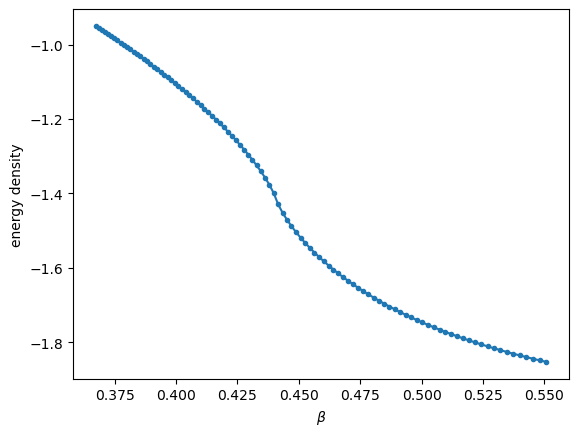

In [8]:
import matplotlib
import matplotlib.pyplot as plt
plt.plot(1/Ts,Ts*Ts*dlnZdT_th,marker='.')
plt.xlabel(r'$\beta$')
plt.ylabel(r'energy density')

Text(0, 0.5, 'heat capacity')

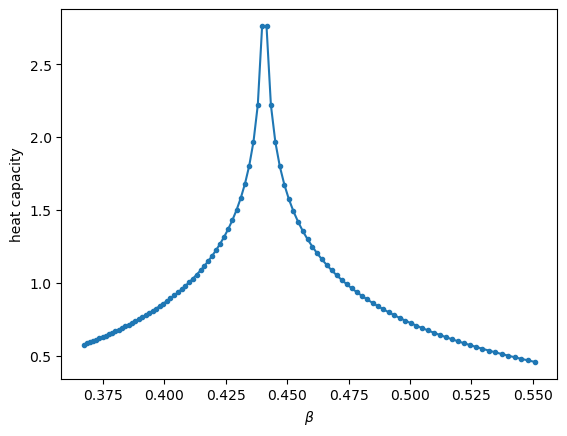

In [9]:
plt.plot(1/Ts,2*Ts*dlnZdT_th+Ts*Ts*d2lnZdT2_th,marker='.')
plt.xlabel(r'$\beta$')
plt.ylabel(r'heat capacity')

In [12]:
import numpy as np
Tc = models.Ising2D.Tc
dlnZdT_RG= []
d2lnZdT2_RG = []
lnZ_RG = []
for T in np.linspace(0.8*Tc,1.2*Tc,Nsamples)[:]:
  #with torch.autograd.detect_anomaly():
  temp = torch.Tensor([T]).to(device)
  temp.requires_grad_()
  model = models.Ising2D(temp)
  hotrg = hotrg_torch.HOTRG(model,15,disable_ckpt=True)
  hotrg.run(20,verbose=True)
  lnZ = hotrg.get_lnZ()

  # Compute derivatives
  dlnZdT, = torch.autograd.grad(lnZ,temp,create_graph=True)
  
  d2lnZdT2, = torch.autograd.grad(dlnZdT,temp)
  lnZ_RG.append(lnZ.item())
  dlnZdT_RG.append(dlnZdT.item())
  d2lnZdT2_RG.append(d2lnZdT2.item())

Renormalizing Ising2D
Current lattice size: 1	Current iterations: 0
Printing logs every 2 steps
Iteration:  0 Size 2.000e+00 RG lnZ:  2.51807858011731 Theory lnZ:  1.1175828266057495 Error: 5.5618e-01
Iteration:  2 Size 8.000e+00 RG lnZ:  1.2366423636391795 Theory lnZ:  1.1175828266057495 Error: 9.6276e-02
Iteration:  4 Size 3.200e+01 RG lnZ:  1.153739014637577 Theory lnZ:  1.1175828266057495 Error: 3.1338e-02
Iteration:  6 Size 1.280e+02 RG lnZ:  1.128141169464003 Theory lnZ:  1.1175828266057495 Error: 9.3591e-03
Iteration:  8 Size 5.120e+02 RG lnZ:  1.120289872722066 Theory lnZ:  1.1175828266057495 Error: 2.4164e-03
Iteration:  10 Size 2.048e+03 RG lnZ:  1.1182599883325754 Theory lnZ:  1.1175828266057495 Error: 6.0555e-04
Iteration:  12 Size 8.192e+03 RG lnZ:  1.1176675071780222 Theory lnZ:  1.1175828266057495 Error: 7.5765e-05
Iteration:  14 Size 3.277e+04 RG lnZ:  1.1176039915431395 Theory lnZ:  1.1175828266057495 Error: 1.8938e-05
Iteration:  16 Size 1.311e+05 RG lnZ:  1.117588114

In [27]:
#d2lnZdT2_RG

In [28]:
#result = torch.load('./Ising2D-chi10-T_2.14975.pt')

In [29]:
result['']

NameError: name 'result' is not defined

In [14]:
dlnZdT_RG = np.array(dlnZdT_RG)


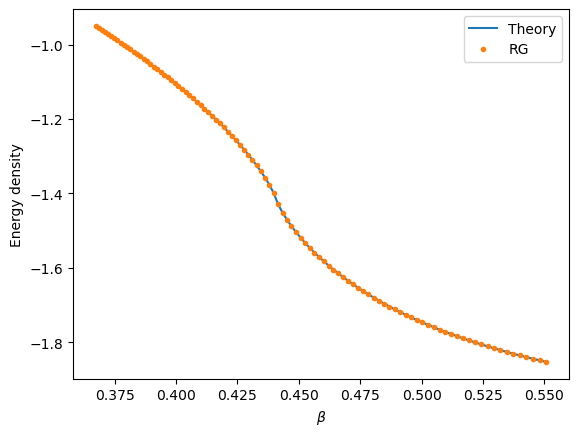

In [24]:

plt.plot(1/Ts,Ts*Ts*dlnZdT_th,label='Theory')
plt.plot(1/Ts,Ts*Ts*dlnZdT_RG,marker='.',linestyle='None',label='RG')
#plt.ylim(-2,-0.8)
plt.xlabel(r'$\beta$')
plt.ylabel(r'Energy density')
plt.legend()

Text(0.5, 0, '$\\beta$')

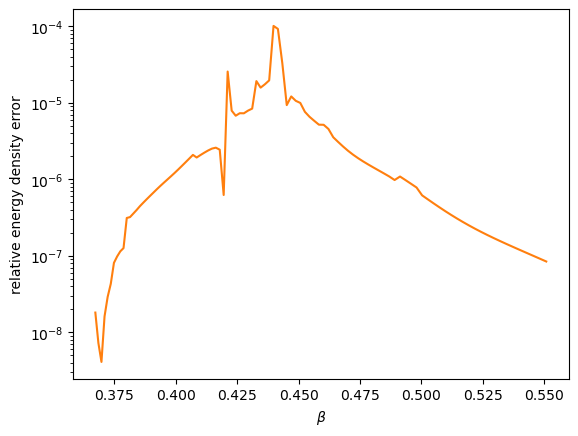

In [16]:
# Energy error 
E_RG = Ts*Ts*dlnZdT_RG
E_th = Ts*Ts*dlnZdT_th

plt.plot(1/Ts,np.abs((E_RG-E_th)/E_th),color='tab:orange')
plt.yscale('log')
plt.ylabel('relative energy density error')
plt.xlabel(r'$\beta$')

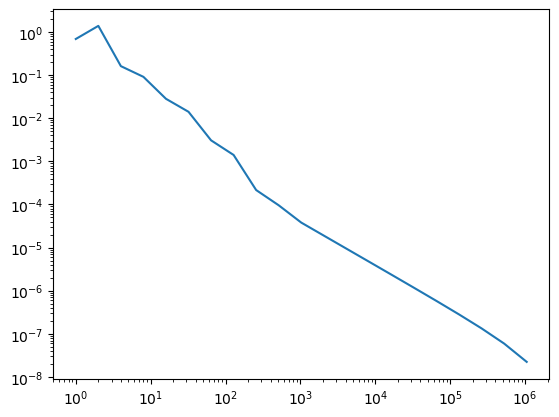

In [13]:
lnZ_RG_np = np.array([hotrg.get_lnZ(i).item() for i in range(hotrg.iter+1)])
lnZ_th_np = hotrg.model.get_lnZ().item()
plt.plot(np.array(hotrg.Nsizes),np.abs(lnZ_th_np-lnZ_RG_np)/np.abs(lnZ_th_np))
plt.yscale('log')
plt.xscale('log')

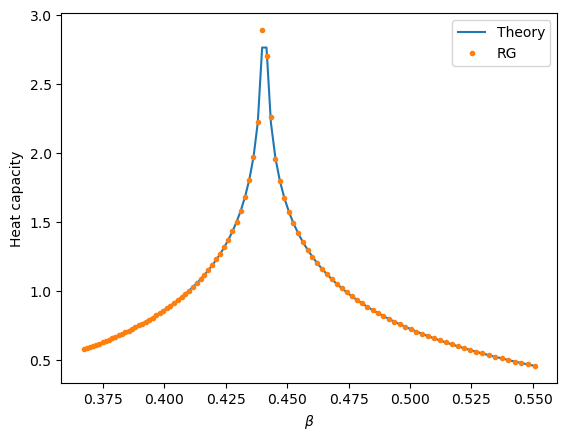

In [23]:

plt.plot(1/Ts,2*Ts*dlnZdT_th+Ts*Ts*d2lnZdT2_th,label='Theory')
plt.plot(1/Ts,2*Ts*dlnZdT_RG+Ts*Ts*d2lnZdT2_RG,marker='.',linestyle='None',label='RG')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Heat capacity')
plt.legend()